In [3]:
from QIP import *

In [2]:
def grovers(goal_state, num_iterations):
    num_qubits = len(goal_state)+1
    circuit = QCircuit(num_qubits)
    
    # h on all except ancilla
    for qubit in range(num_qubits-1):
        circuit.h(qubit)
    # NOT on ancilla    
    circuit.x(num_qubits-1)
    # grover iteration
    for grover_iteration in range(num_iterations):
        # phase flip ancilla controlled by bitstring of goal state
        circuit.apply_to_circuit(arbitrary_U(x,num_qubits,[num_qubits-1],control_bitstring=goal_state))
        
        # h on all except ancilla
        for qubit in range(num_qubits-1):
            circuit.h(qubit)

        # phase flip ancilla if state is all zeros
        circuit.apply_to_circuit(arbitrary_U(z,num_qubits,[num_qubits-1],control_bitstring='0'*len(goal_state)))

        # h on all except ancilla
        for qubit in range(num_qubits-1):
            circuit.h(qubit)
    return circuit

In [3]:
grovers_circuit = grovers('11010',int(2**2.5))

In [10]:
def qft(circuit_size):
        
    circuit = QCircuit(circuit_size)
    
    # Begin the QFT
    for i in range(circuit_size):
        circuit.h(i)
        
        for k in range(2,circuit_size-i+1):
            R_k = np.array([[1.,0.],[0.,np.exp(1.j*2*np.pi/2**k)]])
            circuit.apply_to_circuit(arbitrary_U(R_k,circuit_size,[i],controls=[i+k-1]))
    circuit.reverse_bits()
    return circuit

In [8]:
qft_circuit = qft(3)

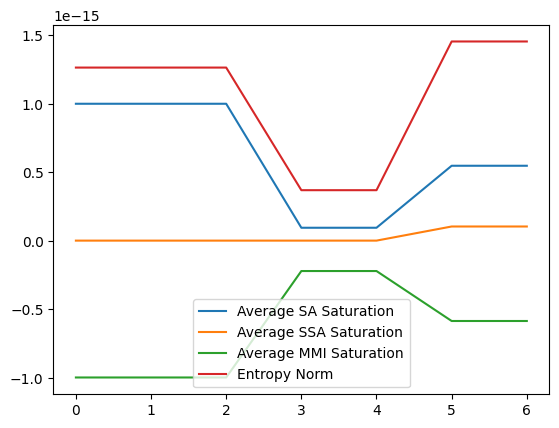

In [20]:
qft_circuit.plot_saturations()

In [4]:
def qft_inverse(circuit_size):
        
    circuit = QCircuit(circuit_size)
    
    # Begin the QFT
    
    # Hadamard on every qubit
    for i in range(circuit_size):
        circuit.h(i)
        
        # Controlled reverse-phase on each qubit 
        for k in range(2,circuit_size-i+1):
            R_k = np.array([[1.,0.],[0.,np.exp(-1.j*2*np.pi/2**k)]])
            circuit.apply_to_circuit(arbitrary_U(R_k,circuit_size,[i],controls=[i+k-1]))
    circuit.reverse_bits()
    return circuit

In [10]:
qft_i_circuit = qft_inverse(3)

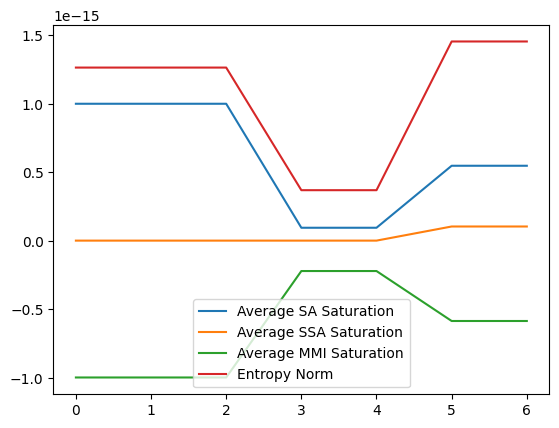

In [19]:
qft_i_circuit.plot_saturations()

In [16]:
def qpe(U,num_auxiliary_bits,eigvec):
    
    m = int(np.log2(np.shape(U)[0]))
    num_qubits = num_auxiliary_bits + m
    circuit = QCircuit(num_qubits,initial_state=np.kron(bitstrings_to_vector('0'*num_auxiliary_bits),eigvec))
    for i in range(num_auxiliary_bits):
        circuit.h(i)
    for k in range(num_auxiliary_bits):
        circuit.apply_to_circuit(arbitrary_U(U**(2**k),num_qubits,list(range(num_auxiliary_bits,num_qubits)),controls=[num_qubits-m-1-k]))
    qfti_circuit = qft_inverse(num_auxiliary_bits)
    #qfti_circuit.reverse_bits()
    circuit.apply_to_circuit(arbitrary_U(qfti_circuit.unitary,num_qubits,list(range(num_auxiliary_bits))))
    return circuit

In [19]:
l = np.random.random()
test_gate = np.array([[1.,0.],[0.,np.exp(np.pi*1.j*l)]])
eigval = np.linalg.eig(test_gate)[0][1]
eigvec = np.linalg.eig(test_gate)[1][:,1]
theta=np.log(eigval)/(2*np.pi*1.j)
print("theta = ",end="")
print(np.round(theta,5))
print("eigenvector:",end="")
print(np.round(eigvec,5))

qpe_circuit = qpe(test_gate,3,eigvec)

theta = (0.32052+0j)
eigenvector:[0.+0.j 1.+0.j]


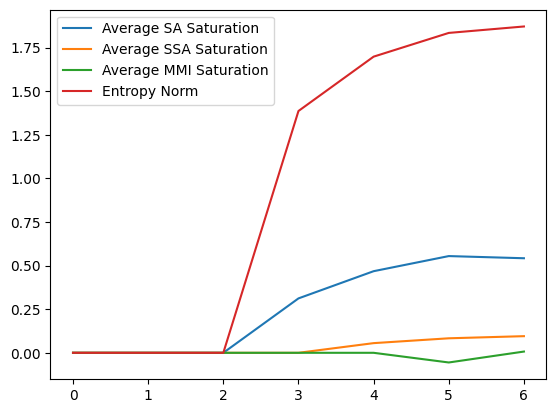

In [25]:
qpe_circuit.plot_saturations()

In [9]:
#Here we build the unitary needed for Shor's. In each step of phase estimation we must construct a new one
def order_finding_U(a,n,N):
    U = np.zeros((2**n,2**n))
    for k in range(2**n):
        if k < N: 
            transformed_k = (a*k)%N
        else: transformed_k = k
        row = np.array(1.)
        for bit in int_to_bitstring(transformed_k,n):
            row = np.kron(row,qubit_map[bit])
        U[k]=row
    return U.T

def order_finding(a,N):
    
    # number of qubits in second register
    n = int(np.ceil(np.log2(N)))
    
    # accuracy and number of qubits in first register
    m = 2*n+1
    
    # now execute the circuit
    circuit = QCircuit(m+n)
    
    # phase estimation step 
    
    # second register starts as |1>
    for q in range(m,n+m):
        circuit.x(q)
    
    # hadamard on all inputs
    for q in range(m):
        circuit.h(q)
    
    # controlled unitaries
    for k in range(m):
        circuit.apply_to_circuit(arbitrary_U(order_finding_U(a**(2**k),n,N),n+m,list(range(m,n+m)),controls=[n-1-k]))
    
    # inverse qft
    qfti_circuit = qft_inverse(m)
    circuit.apply_to_circuit(arbitrary_U(qfti_circuit.unitary,n+m,list(range(m))))
    return circuit
    
    
    

    

In [13]:
shors = order_finding(3,5)

KeyboardInterrupt: 

(array([127.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

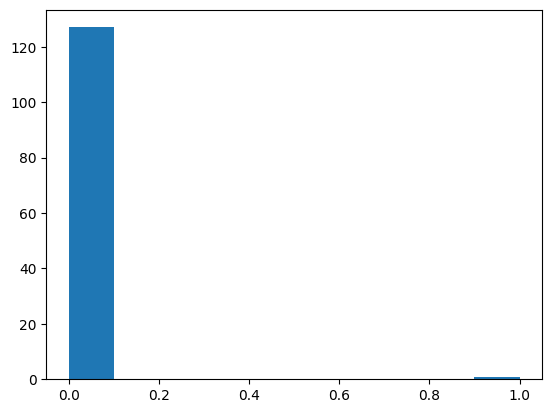

In [11]:
import matplotlib.pyplot as plt
plt.hist([np.abs(s)**2 for s in shors.statevector])

In [20]:
a=8
N=15

n = int(np.ceil(np.log2(N)))
m = 2*n+1
U = np.zeros((2**n,2**n))
for k in range(2**n):
    if k < N: 
        transformed_k = (a*k)%N
    else: transformed_k = k
    row = np.array(1.)
    for bit in int_to_bitstring(transformed_k,n):
        row = np.kron(row,qubit_map[bit])
    U[k]=row
U=U.T
checkOperator(U,form='int')

0 -> 0
1 -> 8
2 -> 1
3 -> 9
4 -> 2
5 -> 10
6 -> 3
7 -> 11
8 -> 4
9 -> 12
10 -> 5
11 -> 13
12 -> 6
13 -> 14
14 -> 7
15 -> 15


In [14]:
for k in range(16):
    print(str(k)+ " -> " + str((a*k)%N))

0 -> 0
1 -> 8
2 -> 1
3 -> 9
4 -> 2
5 -> 10
6 -> 3
7 -> 11
8 -> 4
9 -> 12
10 -> 5
11 -> 13
12 -> 6
13 -> 14
14 -> 7
15 -> 0


In [6]:
test = QCircuit(3)
for q in range(2):
    test.h(q)
state_as_string(test.statevector)

'0.5|000> + 0.5|010> + 0.5|100> + 0.5|110>'

In [7]:
test.measure([0,2])

{'00': 0.4999999999999998, '10': 0.4999999999999998}


In [15]:
class testing:
    def __init__(self,age,initial_test=None):
        if initial_test == None:
            self.age=age
        else: self.__dict__.update(initial_test.__dict__)

dylan = testing(26)
josh=testing(12,initial_test=dylan)
josh.age
    

26

In [9]:
def partial_trace(p,trace_out):
    """finds the reduced density matrix after tracing out the given indices

    Args:
        p (numpy.ndarray (2-d)): full density matrix
        trace_out (list): indices to trace out
    """
    d_b = len(trace_out)
    d_a = int(np.log2(np.shape(p)[0])) - d_b
    sum = 0
    for j in range(2**b):
        vec = np.zeros()
        sum = sum + np.kron(int_to)

In [6]:
a = np.arange(25).reshape(5,5)
b = np.arange(5)
c = np.arange(6).reshape(2,3)

In [8]:
type(a)

numpy.ndarray

In [22]:
from itertools import chain
contacts = [[1,2],[3,4],[5,6],[7,8]]


list(chain([1,2],[3,4],[5,6],[7,8]))


[1, 2, 3, 4, 5, 6, 7, 8]

In [24]:
def my_chain(contacts):
    new_list = []
    for l in contacts:
        for e in l:
            new_list.append(e)
    return new_list
my_chain(contacts)

[1, 2, 3, 4, 5, 6, 7, 8]

In [18]:
new_stupid_list = []
new_stupid_list.append(new_list)
new_stupid_list

[[1, 2, 3, 4, 5, 6, 7, 8]]